In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import time
from tqdm import tqdm_notebook as tqdm
import re
import ast
import scipy.stats as sp
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)

# Optimizing SVR with RBF Kernel 

## Getting the Dataframe

In [2]:
df = pd.read_pickle("../data/feature_df.pkl")

In [3]:
def no_outliers(df, max_retweets):
    return df[df.retweets <= max_retweets]

max_retweets = 1000

print(df.shape)
df = no_outliers(df, max_retweets)
print(df.shape)

(11027, 41)
(10673, 41)


In [30]:
print(df.shape)
display(df[0:3])

(10673, 41)


,retweets,timestamp,tokenized_words,word_count,tokenized_sentences,text_words_removed,lemmas,word_freq,part_of_speech,named_entity,avg_nouns_per_sentence,avg_verbs_per_sentence,avg_adjs_per_sentence,avg_advs_per_sentence,skew_nouns_per_sentence,skew_verbs_per_sentence,skew_adjs_per_sentence,skew_advs_per_sentence,sd_nouns_per_sentence,sd_verbs_per_sentence,sd_adjs_per_sentence,sd_advs_per_sentence,kurt_nouns_per_sentence,kurt_verbs_per_sentence,kurt_adjs_per_sentence,kurt_advs_per_sentence,avg_sentence_length,skew_sentence_length,kurt_sentence_length,sd_sentence_length,noun_count,adj_count,adv_count,verb_count,avg_word_freq,num_entities,num_people,avg_word_len,avg_word_sd,avg_word_skew,avg_word_kur
0,54,2019-10-14 23:45:05,"[Cara, Buckley, Tyler, Perry, hears, voices, i...",1332,[Cara Buckley Tyler Perry hears voices in his ...,"['Cara', 'Buckley', 'Tyler', 'Perry', 'hears',...","{Cara: 'Cara', Buckley: 'Buckley', Tyler: 'Tyl...","Counter({'Perry': 23, 'said': 13, 'black': 12,...","{Cara: 'PROPN', Buckley: 'PROPN', Tyler: 'PROP...","{'LAW': ['the Ultimate Icon Award '], 'TIME': ...",3.687500,2.828125,1.625000,0.906250,1.003368,1.072613,0.772419,0.842893,2.894302,1.741689,1.327368,1.019162,0.850445,3.228395,0.824951,-0.446330,24.796875,0.801164,1.138566,14.053390,232,105,58,183,1.359667,72,20,4.493994,2.320905,0.984621,0.629332
1,18,2019-10-14 23:30:07,"[Robert, Leonard, Mr, Leonard, is, the, author...",1160,[Robert Leonard Mr Leonard is the author of De...,"['Robert', 'Leonard', 'Mr', 'Leonard', 'author...","{Robert: 'Robert', Leonard: 'Leonard', Mr: 'Mr...","Counter({'Mr': 16, 'Trump': 12, 'King': 9, 'Io...","{Robert: 'PROPN', Leonard: 'PROPN', Mr: 'PROPN...","{'TIME': ['the morning ', 'the evening '], 'PR...",3.071429,1.628571,1.342857,0.914286,0.867576,1.056125,1.087943,1.193777,2.403629,1.456335,1.360794,0.988966,0.837986,1.625183,0.944929,1.353088,19.800000,0.353036,-0.355596,10.091753,208,89,61,118,1.448529,70,25,4.722414,2.655933,1.183618,1.660002
2,39,2019-10-14 23:15:04,"[Shuhan, Fan, and, Luther, Clement, Ms, Fan, a...",237,"[Shuhan Fan and Luther Clement, Ms Fan and Mr ...","['Shuhan', 'Fan', 'Luther', 'Clement', 'Ms', '...","{Shuhan: 'Shuhan', Fan: 'Fan', and: 'and', Lut...","Counter({'film': 6, 'Keeth': 5, 'Fan': 2, 'Lut...","{Shuhan: 'PROPN', Fan: 'PROPN', and: 'CCONJ', ...","{'ORG': ['Peter Westbrook Foundation ', 'the P...",3.333333,2.750000,1.166667,0.750000,0.252117,0.052602,1.009002,0.477594,2.839121,1.912875,1.337116,0.753778,-1.306829,-0.864689,0.204769,-0.868267,22.250000,-0.248484,-1.151573,11.250253,40,15,9,33,1.198020,14,7,4.624473,2.388066,0.949981,0.710818


In [4]:
# get transformed df 

titles = ['word_count', 'avg_nouns_per_sentence',
           'avg_verbs_per_sentence', 'avg_adjs_per_sentence',
           'avg_advs_per_sentence', 'sd_nouns_per_sentence',
           'sd_verbs_per_sentence', 'sd_adjs_per_sentence', 'sd_advs_per_sentence',
           'kurt_nouns_per_sentence', 'kurt_verbs_per_sentence',
           'kurt_adjs_per_sentence', 'kurt_advs_per_sentence',
           'avg_sentence_length', 'skew_sentence_length', 'kurt_sentence_length',
           'sd_sentence_length', 'noun_count', 'adj_count', 'adv_count',
           'verb_count', 'avg_word_freq', 'num_entities', 'num_people',
           'avg_word_skew', 'avg_word_kur']

c = 1e-3
df_transform = df
for i in range(len(titles)):
    df_transform[titles[i] + "_inverse"] = df[titles[i]].apply(lambda x: 1/(x+c))

for i in range(len(titles)):
    df_transform[titles[i] + "_sqrt"] = df[titles[i]].apply(lambda x: np.sqrt(x))
    
df_transform = no_outliers(df_transform, 1000)

In [32]:
print(df_transform.shape)
display(df_transform[0:3])

(10673, 93)


,retweets,timestamp,tokenized_words,word_count,tokenized_sentences,text_words_removed,lemmas,word_freq,part_of_speech,named_entity,avg_nouns_per_sentence,avg_verbs_per_sentence,avg_adjs_per_sentence,avg_advs_per_sentence,skew_nouns_per_sentence,skew_verbs_per_sentence,skew_adjs_per_sentence,skew_advs_per_sentence,sd_nouns_per_sentence,sd_verbs_per_sentence,sd_adjs_per_sentence,sd_advs_per_sentence,kurt_nouns_per_sentence,kurt_verbs_per_sentence,kurt_adjs_per_sentence,kurt_advs_per_sentence,avg_sentence_length,skew_sentence_length,kurt_sentence_length,sd_sentence_length,noun_count,adj_count,adv_count,verb_count,avg_word_freq,num_entities,num_people,avg_word_len,avg_word_sd,avg_word_skew,avg_word_kur,word_count_inverse,avg_nouns_per_sentence_inverse,avg_verbs_per_sentence_inverse,avg_adjs_per_sentence_inverse,avg_advs_per_sentence_inverse,sd_nouns_per_sentence_inverse,sd_verbs_per_sentence_inverse,sd_adjs_per_sentence_inverse,sd_advs_per_sentence_inverse,kurt_nouns_per_sentence_inverse,kurt_verbs_per_sentence_inverse,kurt_adjs_per_sentence_inverse,kurt_advs_per_sentence_inverse,avg_sentence_length_inverse,skew_sentence_length_inverse,kurt_sentence_length_inverse,sd_sentence_length_inverse,noun_count_inverse,adj_count_inverse,adv_count_inverse,verb_count_inverse,avg_word_freq_inverse,num_entities_inverse,num_people_inverse,avg_word_skew_inverse,avg_word_kur_inverse,word_count_sqrt,avg_nouns_per_sentence_sqrt,avg_verbs_per_sentence_sqrt,avg_adjs_per_sentence_sqrt,avg_advs_per_sentence_sqrt,sd_nouns_per_sentence_sqrt,sd_verbs_per_sentence_sqrt,sd_adjs_per_sentence_sqrt,sd_advs_per_sentence_sqrt,kurt_nouns_per_sentence_sqrt,kurt_verbs_per_sentence_sqrt,kurt_adjs_per_sentence_sqrt,kurt_advs_per_sentence_sqrt,avg_sentence_length_sqrt,skew_sentence_length_sqrt,kurt_sentence_length_sqrt,sd_sentence_length_sqrt,noun_count_sqrt,adj_count_sqrt,adv_count_sqrt,verb_count_sqrt,avg_word_freq_sqrt,num_entities_sqrt,num_people_sqrt,avg_word_skew_sqrt,avg_word_kur_sqrt
0,54,2019-10-14 23:45:05,"[Cara, Buckley, Tyler, Perry, hears, voices, i...",1332,[Cara Buckley Tyler Perry hears voices in his ...,"['Cara', 'Buckley', 'Tyler', 'Perry', 'hears',...","{Cara: 'Cara', Buckley: 'Buckley', Tyler: 'Tyl...","Counter({'Perry': 23, 'said': 13, 'black': 12,...","{Cara: 'PROPN', Buckley: 'PROPN', Tyler: 'PROP...","{'LAW': ['the Ultimate Icon Award '], 'TIME': ...",3.687500,2.828125,1.625000,0.906250,1.003368,1.072613,0.772419,0.842893,2.894302,1.741689,1.327368,1.019162,0.850445,3.228395,0.824951,-0.446330,24.796875,0.801164,1.138566,14.053390,232,105,58,183,1.359667,72,20,4.493994,2.320905,0.984621,0.629332,0.000751,0.271113,0.353466,0.615006,1.102232,0.345387,0.573826,0.752804,0.980237,1.174474,0.309656,1.210725,-2.245527,0.040326,1.246628,0.877527,0.071152,0.004310,0.009524,0.017241,0.005464,0.734933,0.013889,0.049998,1.014589,1.586466,36.496575,1.920286,1.681703,1.274755,0.951972,1.701265,1.319731,1.152114,1.009535,0.922196,1.796773,0.908268,NaN,4.979646,0.895078,1.067036,3.748785,15.231546,10.246951,7.615773,13.527749,1.166048,8.485281,4.472136,0.992280,0.793304
1,18,2019-10-14 23:30:07,"[Robert, Leonard, Mr, Leonard, is, the, author...",1160,[Robert Leonard Mr Leonard is the author of De...,"['Robert', 'Leonard', 'Mr', 'Leonard', 'author...","{Robert: 'Robert', Leonard: 'Leonard', Mr: 'Mr...","Counter({'Mr': 16, 'Trump': 12, 'King': 9, 'Io...","{Robert: 'PROPN', Leonard: 'PROPN', Mr: 'PROPN...","{'TIME': ['the morning ', 'the evening '], 'PR...",3.071429,1.628571,1.342857,0.914286,0.867576,1.056125,1.087943,1.193777,2.403629,1.456335,1.360794,0.988966,0.837986,1.625183,0.944929,1.353088,19.800000,0.353036,-0.355596,10.091753,208,89,61,118,1.448529,70,25,4.722414,2.655933,1.183618,1.660002,0.000862,0.325475,0.613658,0.744127,1.092555,0.415865,0.686184,0.734326,1.010136,1.191915,0.614937,1.057162,0.738504,0.050502,2.824568,-2.820109,0.099081,0.004808,0.011236,0.016393,0.008475,0.689879,0.014286,0.039998,0.844154,0.602046,34.058773,1.752549,1.276155,1.15

## Implementing SVR and Bagging SVR with RBF Kernel

In [5]:
from sklearn.model_selection import train_test_split
import scipy.stats as stats

def get_xy_split(df):
    df = df.dropna(how='any',axis=0)

    titles = ['word_count', 'avg_nouns_per_sentence',
           'avg_verbs_per_sentence', 'avg_adjs_per_sentence',
           'avg_advs_per_sentence', 'skew_nouns_per_sentence',
           'skew_verbs_per_sentence', 'skew_adjs_per_sentence',
           'skew_advs_per_sentence', 'sd_nouns_per_sentence',
           'sd_verbs_per_sentence', 'sd_adjs_per_sentence', 'sd_advs_per_sentence',
           'kurt_nouns_per_sentence', 'kurt_verbs_per_sentence',
           'kurt_adjs_per_sentence', 'kurt_advs_per_sentence',
           'avg_sentence_length', 'skew_sentence_length', 'kurt_sentence_length',
           'sd_sentence_length', 'noun_count', 'adj_count', 'adv_count',
           'verb_count', 'avg_word_freq', 'num_entities', 'num_people',
           'avg_word_len', 'avg_word_sd', 'avg_word_skew', 'avg_word_kur']

    X = df[titles].copy().values

    y = df[['retweets']].copy().values
    y = np.ravel(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    return X_train, X_test, y_train, y_test

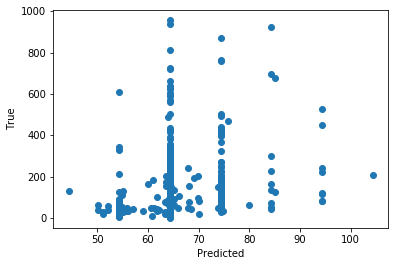

Kendall tau =  0.250724663492209
p-value =  4.851177777574923e-21


In [7]:
# rbf kernel 

from sklearn import svm

X_train, X_test, y_train, y_test = get_xy_split(df_transform)

clf = svm.SVR(kernel='rbf', gamma = 'auto', C = 10)
clf.fit(X_train, y_train) 

pred = clf.predict(X_test)

plt.plot(pred, y_test, 'o')
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()

tau, p_value = stats.kendalltau(pred, y_test)

print("Kendall tau = ", tau)
print("p-value = ", p_value)

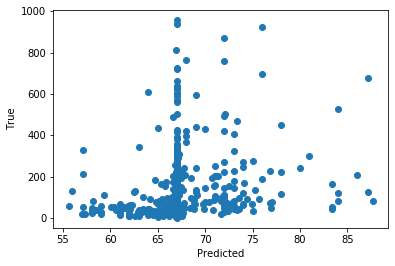

Kendall tau =  0.20675929719340708
p-value =  6.463060041407517e-16


In [8]:
## Ensemble SVM regressor for entire dataset

from sklearn.ensemble import BaggingRegressor
from sklearn import svm

X_train, X_test, y_train, y_test = get_xy_split(df_transform)

bag = BaggingRegressor(svm.SVR(kernel = 'rbf', gamma = 'auto', C = 10), max_samples=0.5, max_features=0.5)
bag.fit(X_train, y_train)

pred = bag.predict(X_test)

plt.plot(pred, y_test, 'o')
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()

tau, p_value = stats.kendalltau(pred, y_test)

print("Kendall tau = ", tau)
print("p-value = ", p_value)

## Optimizing Parameters C and Gamma for SVR Methods

In [6]:
# function to automate model generation
def svr_bag_tau(df, gamma, C):
    from sklearn.ensemble import BaggingRegressor
    from sklearn import svm
    
    X_train, X_test, y_train, y_test = get_xy_split(df)
    bag = BaggingRegressor(svm.SVR(kernel = 'rbf', gamma = gamma, C = C), max_samples=0.5, max_features=0.5)
    bag.fit(X_train, y_train)
    pred = bag.predict(X_test)
    tau, p_value = stats.kendalltau(pred, y_test)
    
    return tau

def svr_tau(df, gamma, C):
    from sklearn import svm
    
    X_train, X_test, y_train, y_test = get_xy_split(df)
    clf = svm.SVR(kernel='rbf', gamma = gamma, C = C)
    clf.fit(X_train, y_train) 
    pred = clf.predict(X_test)
    tau, p_value = stats.kendalltau(pred, y_test)
    
    return tau

In [7]:
# C_range = np.linspace(1, 100, 20)
C_range = np.logspace(-3, 3, 15)
gamma_range = np.logspace(-3, 3, 15)
param_grid = dict(gamma=gamma_range, C=C_range)

tau_dict = dict()
for i in range(len(C_range)):
    for j in range(len(gamma_range)):
        gamma = gamma_range[j]
        C = C_range[i]
        coord = (C, gamma)
        tau_dict[coord] = svr_tau(df_transform, gamma, C)
        
max_value = max(tau_dict.values())
max_keys = [k for k, v in tau_dict.items() if v == max_value] # getting all keys containing the `maximum`
print(max_value, max_keys)

0.26608468778346717 [(19.306977288832496, 0.3727593720314938)]


In [8]:
C_range = np.logspace(-3, 3, 15)
gamma_range = np.logspace(-3, 3, 15)
param_grid = dict(gamma=gamma_range, C=C_range)

tau_dict_bag = dict()
for i in range(len(C_range)):
    for j in range(len(gamma_range)):
        gamma = gamma_range[j]
        C = C_range[i]
        coord = (C, gamma)
        tau_dict_bag[coord] = svr_bag_tau(df_transform, gamma, C)
        
max_value = max(tau_dict_bag.values())
max_keys = [k for k, v in tau_dict_bag.items() if v == max_value] # getting all keys containing the `maximum`
print(max_value, max_keys)

0.2590897302996511 [(21.842105263157894, 138.9495494373136)]
